# What can you reach in 15 minutes in DC?

This week, I want to reverse the narrative about grocery stores and use isochrone maps to show what is available within a 15 minute walk of a random point in a couple of wards.wards=gpd.read_file('data/Wards_from_2012.geojson')

## Bringing in the Data

First, let's bring in the ward boundaries and clean up that dataset.

In [1]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import networkx as nx
import contextily as ctx
import plotly.express as px
import osmnx as ox

In [2]:
wards=gpd.read_file('data/Wards_from_2012.geojson')

Let's make sure the ward information was brought in with all the information we need.

In [3]:
wards.head()

OBJECTID  WARD    NAME              REP_NAME  \
0         1     6  Ward 6         Charles Allen   
1         2     8  Ward 8     Trayon White, Sr.   
2         3     4  Ward 4  Janeese Lewis George   
3         4     3  Ward 3          Mary M. Cheh   
4         5     5  Ward 5       Kenyan McDuffie   

                                             WEB_URL       REP_PHONE  \
0  https://www.dccouncil.us/council/councilmember...  (202) 724-8072   
1  https://www.dccouncil.us/council/councilmember...  (202) 724-8045   
2  https://dccouncil.us/council/ward-4-councilmem...  (202) 724-8052   
3  https://www.dccouncil.us/council/council-membe...  (202) 724-8062   
4       https://dccouncil.us/council/kenyan-mcduffie  (202) 724-8028   

                   REP_EMAIL                                  REP_OFFICE  \
0        callen@dccouncil.us  1350 Pennsylvania Ave, Suite 406, NW 20004   
1        twhite@dccouncil.us  1350 Pennsylvania Ave, Suite 400, NW 20004   
2  jlewisgeorge@dccouncil.us  1350 Pennsylvania Ave, Suite 105, NW 20004   
3         mcheh@dccouncil.us  1350 Pennsylvania Ave, Suite 108, NW 20004   
4     kmcduffie@dccouncil.us  1350 Pennsylvania Ave, Suite 506, NW 20004   

  WARD_ID   LABEL  ...  BACH_DEGREE_25_PLUS  MED_VAL_OOU  \
0       6  Ward 6  ...                19588       573200   
1       8  Ward 8  ...                 3781       229900   
2       4  Ward 4  ...                13032       491300   
3       3  Ward 3  ...                19166       823800   
4       5  Ward 5  ...                11557       379800   

                                 GLOBALID  CREATOR CREATED EDITOR EDITED  \
0  {5D2A5470-9BA3-4C94-9A21-46B5DBFF70D4}     None    None   None   None   
1  {47803E60-D3B3-4445-A139-9456F9B20BED}     None    None   None   None   
2  {C0E0D035-7F66-4819-887B-1575851278F3}     None    None   None   None   
3  {E6E33839-8446-458B-B7E9-BE071089193C}     None    None   None   None   
4  {7969341D-A3BD-4D6B-8257-F5DE354D001A}     None    None   None   None   

  SHAPEAREA SHAPELEN                                           geometry  
0         0        0  POLYGON ((-77.01790 38.91410, -77.01801 38.914...  
1         0        0  POLYGON ((-76.97229 38.87286, -76.97240 38.872...  
2         0        0  POLYGON ((-77.04097 38.99597, -77.07174 38.971...  
3         0        0  POLYGON ((-77.05808 38.95676, -77.05809 38.956...  
4         0        0  POLYGON ((-76.99144 38.95730, -76.99163 38.957...  

[5 rows x 86 columns]

There's a lot of cool information here but I think I'll only need 'WARD' and 'geometry' so I'll cut out the rest.

In [4]:
trim_columns=['WARD','NAME','geometry']
wards_trimmed = wards[trim_columns].copy()
wards_trimmed = wards_trimmed.dropna()
wards_trimmed.sample

<bound method NDFrame.sample of    WARD    NAME                                           geometry
0     6  Ward 6  POLYGON ((-77.01790 38.91410, -77.01801 38.914...
1     8  Ward 8  POLYGON ((-76.97229 38.87286, -76.97240 38.872...
2     4  Ward 4  POLYGON ((-77.04097 38.99597, -77.07174 38.971...
3     3  Ward 3  POLYGON ((-77.05808 38.95676, -77.05809 38.956...
4     5  Ward 5  POLYGON ((-76.99144 38.95730, -76.99163 38.957...
5     1  Ward 1  POLYGON ((-77.03523 38.93743, -77.03570 38.937...
6     2  Ward 2  POLYGON ((-77.04946 38.91999, -77.04973 38.920...
7     7  Ward 7  POLYGON ((-76.94186 38.91854, -76.94200 38.918...>

Now let's see what the ward boundaries look like...

<AxesSubplot: >

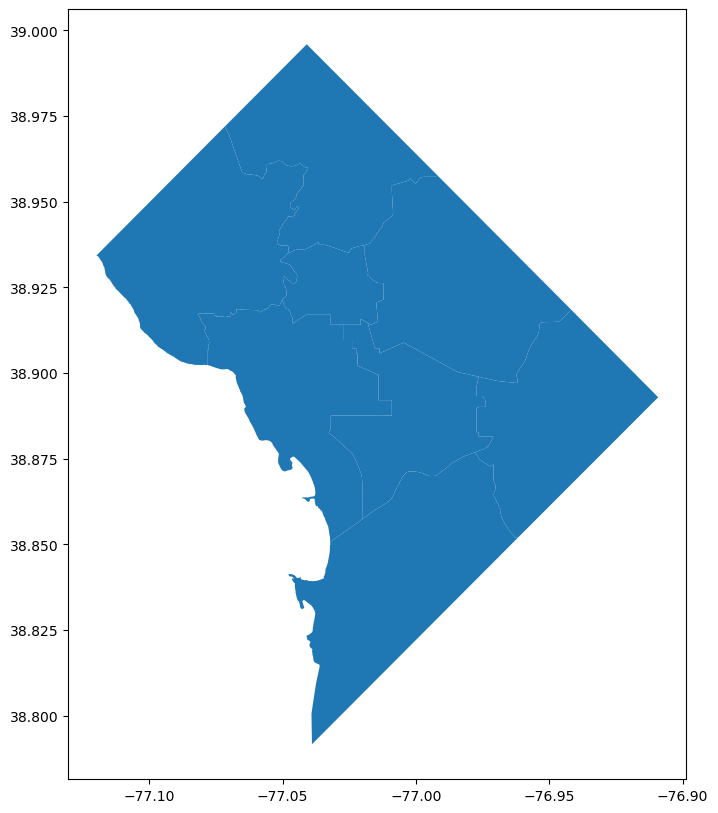

In [5]:
wards_trimmed.plot(figsize=(12,10))

Let's double check the projections to make sure we're all on the same page.

In [6]:
wards_trimmed.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Since we'll be working with distances, I want to convert this into CRS 3857 

In [7]:
wards_trimmed = wards_trimmed.to_crs(epsg=3857)

In [8]:
wards_trimmed.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Now that we have done that, let's find a point in wards 2, 7, and 8 to compare.

## Ward 2 Isochrone Map

I will use the information from the notebook, "vehicle_access_clean" where we found a variety of areas that are more than 10 minutes walking from a grocery store and have over 50% of households lacking vehicle access. I found the centroids of the polygons where these areas overlap and will use the following point randomly pulled from the list:

109    POINT (-77.03655 38.90197)

In [9]:
wards_trimmed.info(verbose=True, show_counts=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   WARD      8 non-null      int64   
 1   NAME      8 non-null      object  
 2   geometry  8 non-null      geometry
dtypes: geometry(1), int64(1), object(1)
memory usage: 320.0+ bytes


In [10]:
wards_trimmed.sample(8)

WARD    NAME                                           geometry
6     2  Ward 2  POLYGON ((-8577106.127 4710217.991, -8577136.5...
7     7  Ward 7  POLYGON ((-8565128.878 4710010.273, -8565144.4...
1     8  Ward 8  POLYGON ((-8568515.991 4703476.145, -8568528.3...
5     1  Ward 1  POLYGON ((-8575522.893 4712713.561, -8575574.5...
2     4  Ward 4  POLYGON ((-8576161.160 4721094.045, -8579586.8...
3     3  Ward 3  POLYGON ((-8578066.424 4715479.621, -8578067.0...
4     5  Ward 5  POLYGON ((-8570647.344 4715557.514, -8570668.8...
0     6  Ward 6  POLYGON ((-8573592.972 4709373.944, -8573606.0...

Now, let's query the data to focus on Ward 2.

In [11]:
ward2=wards_trimmed[wards_trimmed['NAME']=='Ward 2']

So I picked a random point in Ward 2 to center the map. Here are the coordinates from Google Maps: (38.90996956282022, -77.03873750857377). I'll define the trip times for walking using 75 meters per minute, which is the standard time discussed in class.

In [12]:
latlon=[38.90197, -77.03655]
network_type = 'walk'
trip_times = [5,10,15]
meters_per_minute = 75

Okay, now that we have set the parameters, let's bring in the nodes and networks.

In [13]:
G = ox.graph_from_point(latlon, network_type=network_type, dist = 2000)

Now, let's switch to a coordinate system to make it easier to measure distances.

In [14]:
G = ox.project_graph(G, to_crs='epsg:3857')

Next, I'll convert it into a geodata frame that extracts the nodes and edges we will need to define the street network.

In [15]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

Let's double check and see if the right points came through for the nodes.

In [16]:
gdf_nodes.sample(10)

y             x  street_count        lon        lat  \
osmid                                                                         
10170220124  4.707747e+06 -8.576144e+06             4 -77.040812  38.902722   
804598085    4.707238e+06 -8.576661e+06             3 -77.045456  38.899167   
6936201787   4.707720e+06 -8.574287e+06             4 -77.024130  38.902533   
8476470903   4.706243e+06 -8.573523e+06             4 -77.017272  38.892208   
4979651979   4.707129e+06 -8.576007e+06             3 -77.039585  38.898403   
641116233    4.707719e+06 -8.576547e+06             3 -77.044430  38.902526   
8385417360   4.707548e+06 -8.576746e+06             4 -77.046219  38.901328   
3027733412   4.706739e+06 -8.575158e+06             4 -77.031953  38.895676   
9136839303   4.708126e+06 -8.577019e+06             3 -77.048671  38.905376   
3455057004   4.706750e+06 -8.576351e+06             3 -77.042674  38.895749   

              highway                          geometry  
osmid                                                    
10170220124  crossing  POINT (-8576143.962 4707746.926)  
804598085         NaN  POINT (-8576660.885 4707238.385)  
6936201787        NaN  POINT (-8574286.930 4707719.876)  
8476470903        NaN  POINT (-8573523.490 4706243.034)  
4979651979        NaN  POINT (-8576007.317 4707129.090)  
641116233         NaN  POINT (-8576546.716 4707718.832)  
8385417360   crossing  POINT (-8576745.867 4707547.523)  
3027733412   crossing  POINT (-8575157.761 4706739.052)  
9136839303        NaN  POINT (-8577018.811 4708126.488)  
3455057004        NaN  POINT (-8576351.261 4706749.537)

Looks good! Let's see what the nodes look like:

<AxesSubplot: >

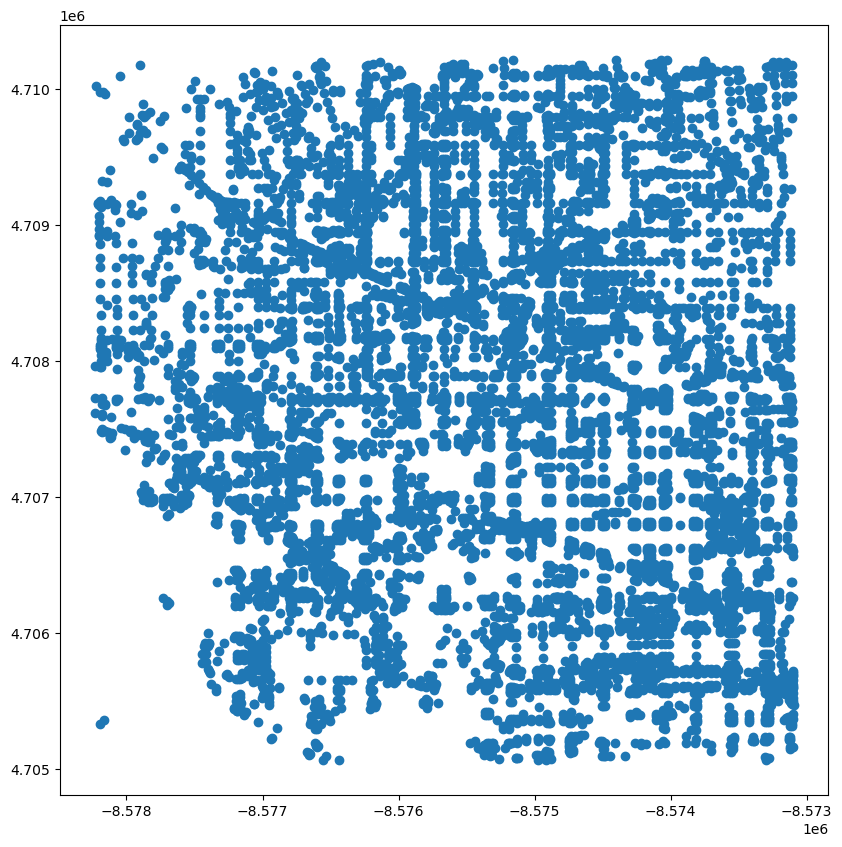

In [17]:
gdf_nodes.plot(figsize=(10,10))

So that could be anything, but it looks cool. Now I want to double check the edges to see what the street networks are and make sure we can use then to calculate walking distances.

In [18]:
gdf_edges.head()

osmid                     name      highway  \
u        v          key                                                    
49716899 49716904   0      6051300  Twining Court Northwest  residential   
         49779907   0    130889721       P Street Northwest    secondary   
         49741730   0    130889721       P Street Northwest    secondary   
49716904 49716899   0      6051300  Twining Court Northwest  residential   
         5447675534 0    161838107                      NaN      service   

                         oneway reversed  length lanes  \
u        v          key                                  
49716899 49716904   0     False    False  42.056   NaN   
         49779907   0     False    False  93.283     4   
         49741730   0     False     True  93.864     4   
49716904 49716899   0     False     True  42.056   NaN   
         5447675534 0     False     True  15.679   NaN   

                                                                  geometry  \
u        v          key                                                      
49716899 49716904   0    LINESTRING (-8576912.946 4708737.045, -8576913...   
         49779907   0    LINESTRING (-8576912.946 4708737.045, -8577021...   
         49741730   0    LINESTRING (-8576912.946 4708737.045, -8576805...   
49716904 49716899   0    LINESTRING (-8576913.469 4708682.941, -8576912...   
         5447675534 0    LINESTRING (-8576913.469 4708682.941, -8576913...   

                        service junction  ref maxspeed bridge width tunnel  \
u        v          key                                                      
49716899 49716904   0       NaN      NaN  NaN      NaN    NaN   NaN    NaN   
         49779907   0       NaN      NaN  NaN      NaN    NaN   NaN    NaN   
         49741730   0       NaN      NaN  NaN      NaN    NaN   NaN    NaN   
49716904 49716899   0       NaN      NaN  NaN      NaN    NaN   NaN    NaN   
         5447675534 0     alley      NaN  NaN      NaN    NaN   NaN    NaN   

                        access  
u        v          key         
49716899 49716904   0      NaN  
         49779907   0      NaN  
         49741730   0      NaN  
49716904 49716899   0      NaN  
         5447675534 0      NaN

Ooh I recognize some of these roads! Now let's map the edges.

<AxesSubplot: >

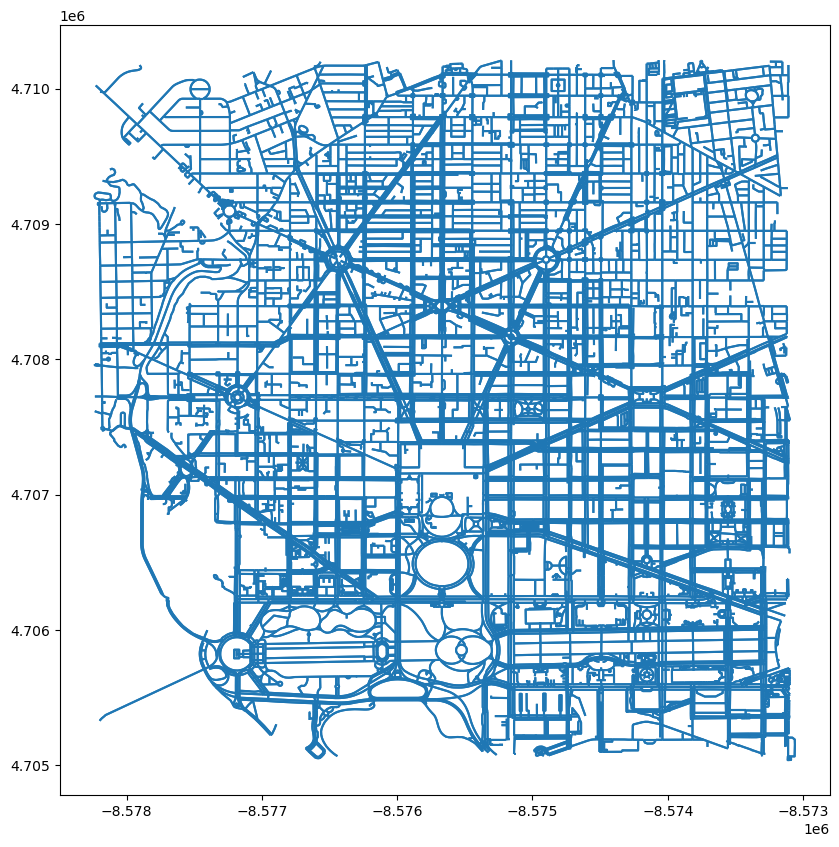

In [19]:
gdf_edges.plot(figsize=(10,10))

Cool, so we see the street network. Let's find the central node in the map by first mapping out the boundaries of the map:

In [20]:
minx, miny, maxx, maxy = gdf_nodes.geometry.total_bounds
print(minx)
print(miny)
print(maxx)
print(maxy)

-8578234.698024705
4705066.960147139
-8573097.080885613
4710212.232952261


We'll calculate an average point that will become the centroid.

In [21]:
centroid_x = (maxx-minx)/2 + minx
centroid_y = (maxy-miny)/2 + miny
print(centroid_x)
print(centroid_y)

-8575665.889455158
4707639.5965497


In [22]:
ward2_node = ox.distance.nearest_nodes(G,Y=centroid_y,X=centroid_x)
print('The id for the nearest node is ' + str(ward2_node))

The id for the nearest node is 9983605761


In [23]:
gdf_nodes.loc[[ward2_node]]

y             x  street_count        lon        lat  \
osmid                                                                        
9983605761  4.707635e+06 -8.575664e+06             3 -77.036502  38.901943   

           highway                          geometry  
osmid                                                 
9983605761     NaN  POINT (-8575664.209 4707635.494)

Now let's map it and see where it is in the network:

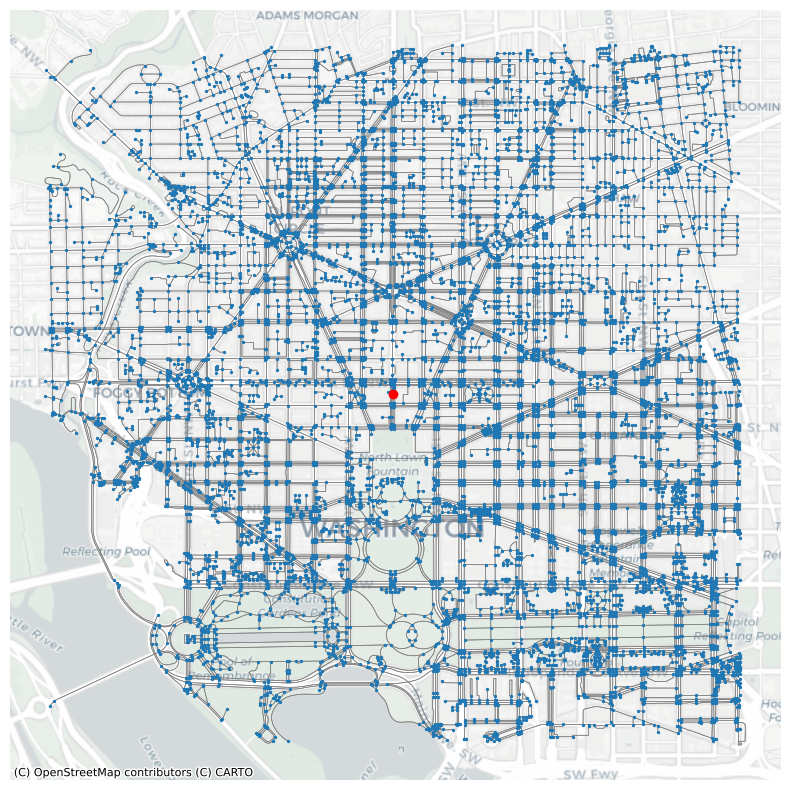

In [24]:
# set up the subplot (single plot = ax)
fig, ax = plt.subplots(figsize=(10,10))

# add the edges to ax
gdf_edges.plot(ax=ax,
               linewidth=0.5,
               edgecolor='gray', 
               zorder=10)

# add all nodes to ax
gdf_nodes.plot(ax=ax, 
               markersize=2, 
               zorder=20)

# add the center node in red also to ax
gdf_nodes.loc[[ward2_node]].plot(ax=ax,
                                  color='r', 
                                  zorder=30)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron,zoom=14)

Perfect, this is exactly where the random point was selected on the map! Let's move onto making the isochrone.

## Making the Isochrone Map for Ward 2

I'm going to calculate walk times and then use that to create an isochrome map around Safeway. First, let's create a new column that calculates walking time under the assumption of 80 meters per minute.

In [25]:
gdf_edges['walk_time'] = gdf_edges['length']/meters_per_minute

Now let's double check and see if the times came out accurately:

In [26]:
gdf_edges[['osmid','name','highway','length','walk_time']].sample(10)

osmid  \
u          v          key                                        
3011762688 2791267375 0                              297304615   
49802539   3522722795 0                              468495088   
3531416324 2791267675 0                                6058518   
8392914644 8392914630 0                              903668976   
49882753   6366542912 0                 [664056259, 397336060]   
5447967248 3140059716 0                               50797102   
6978574890 6978574901 0    [1064040137, 1064040138, 745522557]   
5171896414 5171896413 0                              533035047   
3011565287 6312438642 0                              345259308   
2791594500 8450773237 0                 [296591634, 910156307]   

                                                name      highway  length  \
u          v          key                                                   
3011762688 2791267375 0                          NaN      footway   5.385   
49802539   3522722795 0         7th Street Southwest      primary  15.905   
3531416324 2791267675 0    Corcoran Street Northwest  residential   9.069   
8392914644 8392914630 0                          NaN      footway  30.246   
49882753   6366542912 0        18th Street Northwest    secondary  52.821   
5447967248 3140059716 0        21st Street Northwest     tertiary  42.795   
6978574890 6978574901 0                          NaN      service  44.794   
5171896414 5171896413 0                          NaN      footway   8.829   
3011565287 6312438642 0                          NaN      footway  93.249   
2791594500 8450773237 0                          NaN      footway   9.494   

                           walk_time  
u          v          key             
3011762688 2791267375 0     0.071800  
49802539   3522722795 0     0.212067  
3531416324 2791267675 0     0.120920  
8392914644 8392914630 0     0.403280  
49882753   6366542912 0     0.704280  
5447967248 3140059716 0     0.570600  
6978574890 6978574901 0     0.597253  
5171896414 5171896413 0     0.117720  
3011565287 6312438642 0     1.243320  
2791594500 8450773237 0     0.126587

Now I want to create a color map that reflects distance to the grocery store:

In [27]:
cmap = 'YlGn'

Just want to double check that trip times are 5, 10, and 15 minutes.

In [28]:
trip_times

[5, 10, 15]

Let's use trip times to figure out what colors will be coded in each.

In [29]:
iso_colors = ox.plot.get_colors(n=len(trip_times), 
                                cmap=cmap, 
                                start=0, 
                                return_hex=True)
print(trip_times)
print(iso_colors)

[5, 10, 15]
['#ffffe5', '#77c679', '#004529']


I actually want to invert these colors so that the dark green shows 5 minutes (#004529) while the lighter color reflects 15 minutes away. Let's see if the reverse function works...

In [30]:
new_colors=iso_colors.reverse()
print(trip_times)
print(new_colors)

[5, 10, 15]
None


Yeah guess I have to do it manually.

In [31]:
new_colors=['#004529','#77c679','#ffffe5']
print(new_colors)

['#004529', '#77c679', '#ffffe5']


Let's try to zip these now to pair the list of trip times with the assigned colors:

In [32]:
time_color = list(zip(trip_times, new_colors))
time_color

[(5, '#004529'), (10, '#77c679'), (15, '#ffffe5')]

I'll use a loop to color the nodes around this point based on walking distance. I'll start by inversing the color order so that 15 minutes is first and then 5 minutes is last.

In [33]:
time_color.reverse()
time_color

[(15, '#ffffe5'), (10, '#77c679'), (5, '#004529')]

We want to create a for loop that connects each node within a time frame to a certain color. We'll create an egograph of nodes within this distance and then update the data frame for gdf_nodes with an associated distance color.

In [34]:
for time, color in list(time_color):
  
    subgraph = nx.ego_graph(G, ward2_node, radius=time,distance='time')

    print('There are ' + str(len(subgraph.nodes())) + ' nodes within ' + str(time) + ' minutes ' + color)
    
    for node in subgraph.nodes():
        gdf_nodes.loc[node,'time'] = time
        gdf_nodes.loc[node,'color'] = color

There are 493 nodes within 15 minutes #ffffe5
There are 199 nodes within 10 minutes #77c679
There are 49 nodes within 5 minutes #004529


I want to check gdf_nodes for missing values and assign a color to those:

In [35]:
gdf_nodes.sample(10)

y             x  street_count        lon        lat  \
osmid                                                                        
8437879354  4.705786e+06 -8.574479e+06             3 -77.025855  38.889010   
2790566273  4.707955e+06 -8.574506e+06             4 -77.026101  38.904173   
8776063147  4.710138e+06 -8.573592e+06             3 -77.017884  38.919436   
8177336213  4.708551e+06 -8.575461e+06             4 -77.034680  38.908343   
3011273426  4.706018e+06 -8.573284e+06             3 -77.015120  38.890633   
2998486130  4.708269e+06 -8.574899e+06             3 -77.029629  38.906374   
6379886072  4.706980e+06 -8.577162e+06             4 -77.049959  38.897361   
8480398605  4.705578e+06 -8.573228e+06             3 -77.014615  38.887561   
49809273    4.710086e+06 -8.576586e+06             4 -77.044781  38.919070   
3013359777  4.707103e+06 -8.575139e+06             4 -77.031782  38.898222   

                    highway                          geometry  time color  
osmid                                                                      
8437879354              NaN  POINT (-8574478.968 4705785.625)   NaN   NaN  
2790566273         crossing  POINT (-8574506.341 4707954.500)   NaN   NaN  
8776063147              NaN  POINT (-8573591.629 4710138.046)   NaN   NaN  
8177336213         crossing  POINT (-8575461.306 4708550.942)   NaN   NaN  
3011273426  traffic_signals  POINT (-8573283.942 4706017.702)   NaN   NaN  
2998486130              NaN  POINT (-8574899.076 4708269.339)   NaN   NaN  
6379886072              NaN  POINT (-8577162.224 4706980.105)   NaN   NaN  
8480398605              NaN  POINT (-8573227.725 4705578.381)   NaN   NaN  
49809273               stop  POINT (-8576585.767 4710085.708)   NaN   NaN  
3013359777              NaN  POINT (-8575138.769 4707103.272)   NaN   NaN

We'll make those nodes outside of the 15-minute radius gray so they are visible.

In [36]:
gdf_nodes['color'].fillna('#cccccc', inplace=True)
gdf_nodes.sample(10)

y             x  street_count        lon        lat  \
osmid                                                                        
5214596559  4.707487e+06 -8.578160e+06             3 -77.058922  38.900907   
656725743   4.710104e+06 -8.575465e+06             4 -77.034708  38.919197   
3916466121  4.710046e+06 -8.573163e+06             3 -77.014031  38.918795   
5441147167  4.706895e+06 -8.573426e+06             1 -77.016397  38.896769   
5445790035  4.707598e+06 -8.575889e+06             3 -77.038521  38.901680   
9313425022  4.706805e+06 -8.573109e+06             4 -77.013548  38.896139   
2998488133  4.708320e+06 -8.574988e+06             3 -77.030425  38.906727   
2999213734  4.706604e+06 -8.574164e+06             3 -77.023027  38.894730   
3011273429  4.706144e+06 -8.573284e+06             4 -77.015124  38.891517   
8481317246  4.707374e+06 -8.575683e+06             3 -77.036667  38.900118   

                    highway                          geometry  time    color  
osmid                                                                         
5214596559              NaN  POINT (-8578159.958 4707487.288)   NaN  #cccccc  
656725743   traffic_signals  POINT (-8575464.501 4710103.808)   NaN  #cccccc  
3916466121              NaN  POINT (-8573162.704 4710046.290)   NaN  #cccccc  
5441147167              NaN  POINT (-8573426.108 4706895.458)   NaN  #cccccc  
5445790035              NaN  POINT (-8575888.929 4707597.874)  10.0  #77c679  
9313425022         crossing  POINT (-8573108.892 4706805.276)   NaN  #cccccc  
2998488133              NaN  POINT (-8574987.709 4708319.794)   NaN  #cccccc  
2999213734              NaN  POINT (-8574164.134 4706603.703)   NaN  #cccccc  
3011273429              NaN  POINT (-8573284.331 4706144.276)   NaN  #cccccc  
8481317246              NaN  POINT (-8575682.532 4707374.444)  10.0  #77c679

Now that all nodes should have a color, let's plot it using plotly.

<AxesSubplot: >

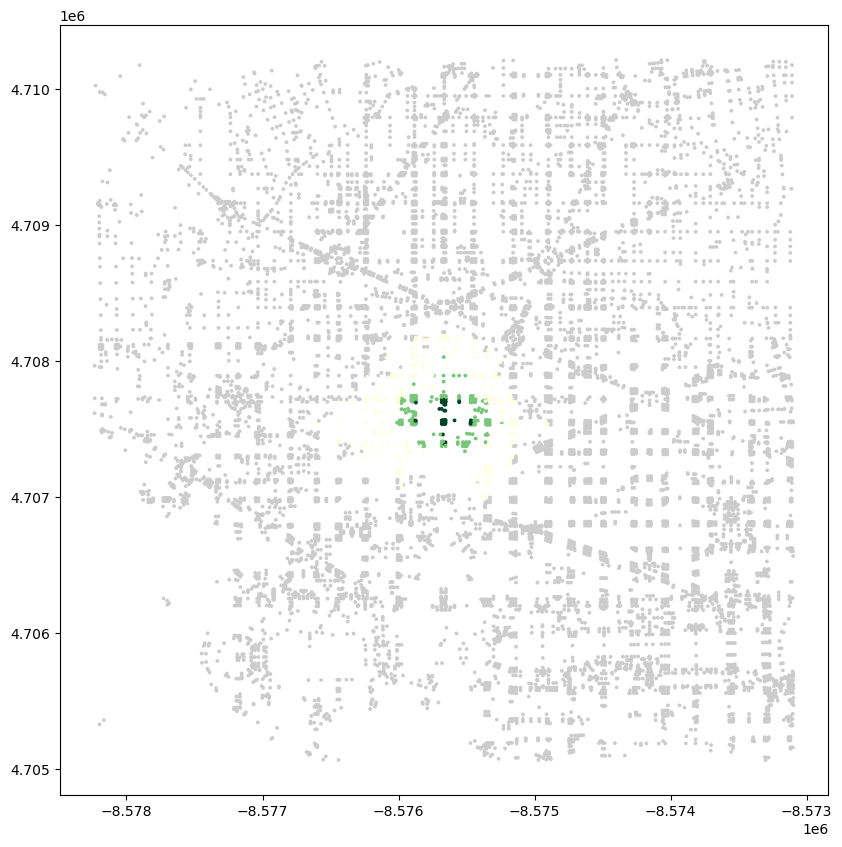

In [37]:
gdf_nodes.plot(figsize=(10,10),
               color=gdf_nodes['color'],
               markersize=3,
               )

No idea why the map is so off center? Let's see if it affects the final product I actually want, which is the polygon.

## Creating the Polygons

First, I'll start out with creating the polygon around points for 5 minute walking distance.

In [38]:
gdf_5 = gdf_nodes[gdf_nodes['time']==5]

Let's plot it and see what points are formed...

<AxesSubplot: >

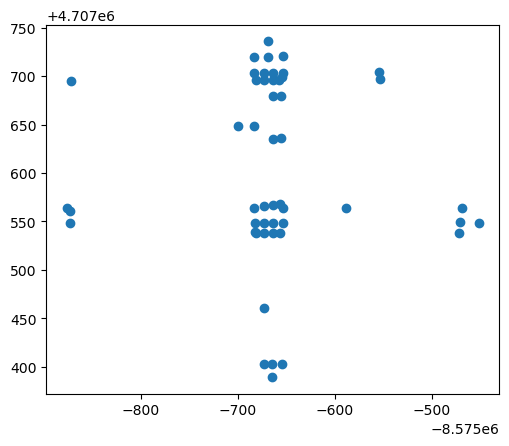

In [39]:
gdf_5.plot()

It doesn't seem like there are a lot of nodes nearby? Maybe it's disconnected from other parts of the city? Let's see what shape it forms using a convex-hull to connect the area between the nodes.

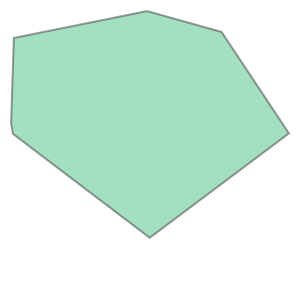

In [40]:
gdf_5.unary_union.convex_hull

Well....that's something. Let's hope the other shapes provide more insight into what's going on around this Safeway. I'll use dissolve for this next part to create polygons around the 5, 10, and 15 minute nodes.

In [41]:
isochrones = gdf_nodes.dissolve(by = "time")
isochrones

geometry             y  \
time                                                                    
5.0   MULTIPOINT (-8575876.528 4707564.130, -8575873...  4.707549e+06   
10.0  MULTIPOINT (-8576010.780 4707547.680, -8575992...  4.707389e+06   
15.0  MULTIPOINT (-8576612.049 4707547.566, -8576599...  4.707292e+06   

                 x  street_count        lon        lat          highway  \
time                                                                      
5.0  -8.575452e+06             4 -77.034593  38.901338  traffic_signals   
10.0 -8.575828e+06             4 -77.037974  38.900223  traffic_signals   
15.0 -8.575158e+06             4 -77.031952  38.899540         crossing   

        color  
time           
5.0   #004529  
10.0  #77c679  
15.0  #ffffe5

We'll convert each row into a convex hull now using the geometry of the multiple nodes.

In [42]:
isochrones = isochrones.convex_hull.reset_index(name='geometry')
isochrones

time                                           geometry
0   5.0  POLYGON ((-8575664.598 4707389.205, -8575873.6...
1  10.0  POLYGON ((-8575512.458 4707337.325, -8575824.0...
2  15.0  POLYGON ((-8575362.700 4706996.740, -8575978.1...

Now, I'll reverse the order so the 15 minute polygon is mapped first.

In [43]:
isochrones.sort_values(by='time', ascending=False,inplace=True)
isochrones

time                                           geometry
2  15.0  POLYGON ((-8575362.700 4706996.740, -8575978.1...
1  10.0  POLYGON ((-8575512.458 4707337.325, -8575824.0...
0   5.0  POLYGON ((-8575664.598 4707389.205, -8575873.6...

Time to plot it and see what is produces!

<AxesSubplot: >

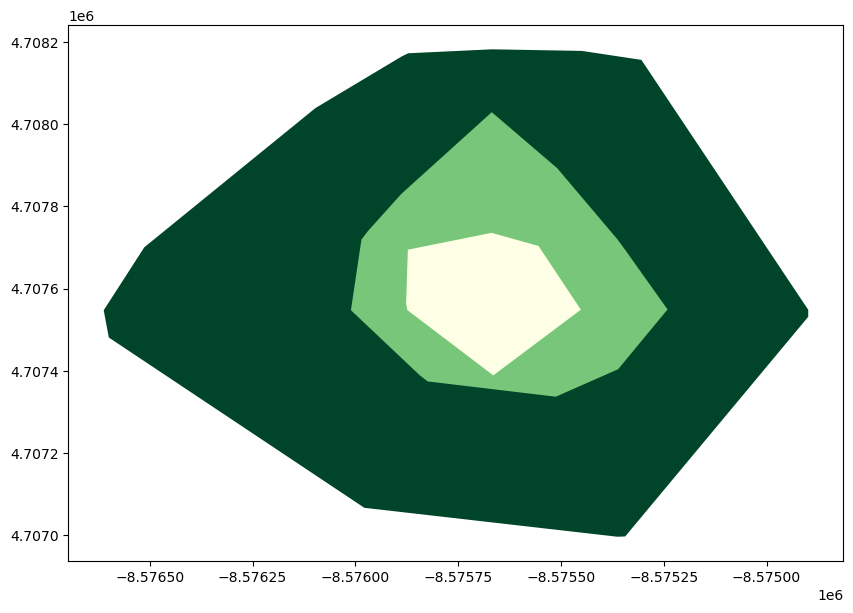

In [44]:
isochrones.plot(figsize=(10,10),alpha=1,color=new_colors, legend=True)

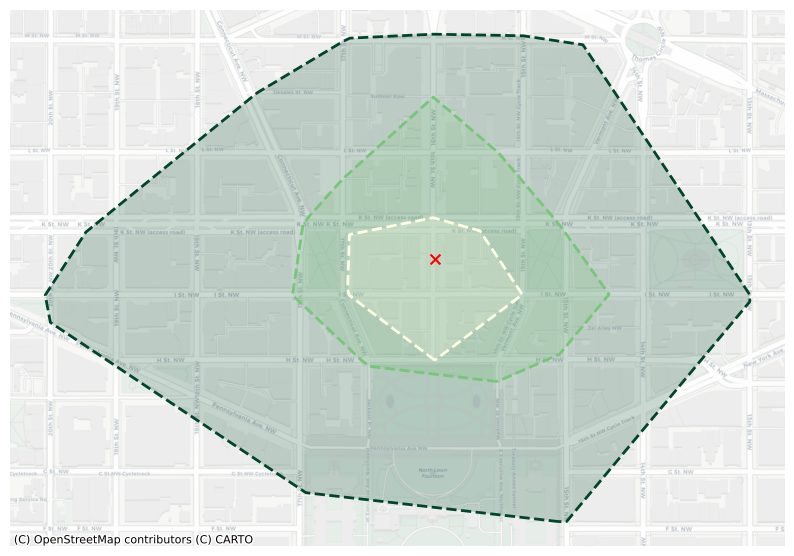

In [45]:
# set up the subplots
fig, ax = plt.subplots(figsize=(10,15))

# add the isochrone boundary
isochrones.boundary.plot(
    ax=ax,
    alpha=1,
    linestyle='--',
    color=new_colors,
    lw=2
    ) 

# add the isochrones
isochrones.plot(
    ax=ax, 
    alpha=0.2, 
    categorical=True, # even though it is numeric, treat it as categorical
    color=new_colors,
    )

# add the center node in red
gdf_nodes.loc[[ward2_node]].plot(ax=ax,color='r',marker='x',markersize=50)

# hide the axis
ax.axis('off')

# add the basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

## Adding in Food Environment Markers to Maps

Now, I'll quickly bring in the data for grocery stores, farmers markets, fast food, liquor licenses, and community gardens to plot them as markers within the isochrone map.

Let's start with grocery stores...

In [46]:
grocery = pd.read_csv('data/Grocery_Store_Locations.csv')

Don't need to clean up everything because I know that we just need the coordinates in order to map everything. I'll turn it into a geodata frame now.

In [47]:
gdf_grocery = gpd.GeoDataFrame(grocery, 
                       crs='epsg:3857',
                       geometry=gpd.points_from_xy(grocery.X, grocery.Y))

In [48]:
gdf_grocery.head()

X          Y                       STORENAME  \
0 -77.026981  38.984455                         Target    
1 -77.026066  38.983464  International Progresso Market   
2 -77.027798  38.967771               Jocelyn’s Market    
3 -77.076459  38.965553                      Magruder's   
4 -77.074910  38.964601                         Safeway   

                      ADDRESS  ZIPCODE       PHONE    WARD           SSL  \
0      7828 GEORGIA AVENUE NW    20012  2028923822  Ward 4  2960    0017   
1      7719 GEORGIA AVENUE NW    20012  2025455015  Ward 4  2961    0810   
2      6404 GEORGIA AVENUE NW    20012  2027227574  Ward 4  2945    0839   
3  5626 CONNECTICUT AVENUE NW    20015  2024644946  Ward 3  1860    0013   
4  5545 CONNECTICUT AVENUE NW    20015  2022446097  Ward 3  1867    0092   

  NOTES PRESENT90  ...     YCOORD  MAR_ID SE_ANNO_CAD_DATA  \
0   NaN       NaN  ...  146280.07  300512              NaN   
1   NaN       NaN  ...  146169.97  285417              NaN   
2   NaN       NaN  ...  144428.00  285334              NaN   
3             Yes  ...  144184.19  263860              NaN   
4              No  ...  144078.34  263999              NaN   

                                 GLOBALID CREATOR                 CREATED  \
0  {CE302122-4E8D-4DC7-845B-06563B993F66}    JLAY  2022/09/28 18:04:54+00   
1  {2C18863D-40DE-4F66-AA59-46F1C65D67F2}    JLAY  2022/09/28 18:04:54+00   
2  {A0B448C3-B3FB-49FE-B8BF-1FEBA3CEA642}    JLAY  2022/09/28 18:04:54+00   
3  {9ABE1C46-BB48-4110-B5BA-C6363CA3BD7A}    JLAY  2022/09/28 18:04:54+00   
4  {902F540E-FE16-43A5-8010-CD84E94B28B7}    JLAY  2022/09/28 18:04:54+00   

  EDITOR                  EDITED PRESENT22                geometry  
0   JLAY  2022/09/28 18:04:54+00       Yes  POINT (-77.027 38.984)  
1   JLAY  2022/09/28 18:04:54+00       Yes  POINT (-77.026 38.983)  
2   JLAY  2022/09/28 18:04:54+00       Yes  POINT (-77.028 38.968)  
3   JLAY  2022/09/28 18:04:54+00       Yes  POINT (-77.076 38.966)  
4   JLAY  2022/09/28 18:04:54+00       Yes  POINT (-77.075 38.965)  

[5 rows x 37 columns]

Repeating the process of bringing in farmers markets and turning it into a geodata frame:

In [49]:
farmers = pd.read_csv('data/Farmers_Market_Locations.csv')

In [50]:
gdf_farmers=gpd.GeoDataFrame(farmers, 
                       crs='epsg:3857',
                       geometry=gpd.points_from_xy(farmers.X, farmers.Y))

In [51]:
gdf_farmers.head()

X          Y                                               NAME  \
0 -77.075111  38.965166           Chevy Chase/Broad Branch Farmers' Market   
1 -77.033134  38.955829                     14th & Kennedy Farmers' Market   
2 -77.069967  38.947004  New Morning Farmers Market at the Sheridan School   
3 -77.064407  38.944128                                 UDC Farmers Market   
4 -77.024775  38.941371                          Petworth Community Market   

            LAYER                  THEME IMAGE_                   ADDRESS  \
0  Farmers Market  Local Business & Food    NaN  5601 Connecticut Ave. NW   
1  Farmers Market  Local Business & Food    NaN           5425 14th St NW   
2  Farmers Market  Local Business & Food    NaN       3600 Alton Place NW   
3  Farmers Market  Local Business & Food    NaN   4200 Connecticut Ave NW   
4  Farmers Market  Local Business & Food    NaN            4121 9th St NW   

          PHONE                                           VOUCHERS  \
0           NaN                                                NaN   
1           NaN  Accepts SNAP, WIC and senior farmers market nu...   
2  814.448.3904  Accepts WIC, senior farmers market nutrition p...   
3  202-274-7148  Accepts SNAP, WIC and senior farmers market nu...   
4           NaN  Accepts SNAP, WIC and senior farmers market nu...   

   PRIORITY_LEVEL  ... SE_ANNO_CAD_DATA              GIS_ID  \
0             NaN  ...              NaN   FarmersMarketPt_9   
1             NaN  ...              NaN  FarmersMarketPt_10   
2             1.0  ...              NaN  FarmersMarketPt_11   
3             NaN  ...              NaN  FarmersMarketPt_12   
4             NaN  ...              NaN  FarmersMarketPt_13   

                                 GLOBALID CREATOR CREATED EDITOR  \
0  {BA7F2149-421B-4053-9C2F-25BD6C2062D6}     NaN     NaN  DCGIS   
1  {81DB3732-F194-4E23-BD85-4C01FFBA5870}     NaN     NaN  DCGIS   
2  {A796CC2A-E688-4F90-8628-6B1B98172BC2}     NaN     NaN  DCGIS   
3  {0EB6EBBC-82CC-40A2-B5D1-E9B94D306B24}     NaN     NaN  DCGIS   
4  {77E47183-0DCC-4E49-BC54-56780B300A2B}     NaN     NaN  DCGIS   

                   EDITED   LATITUDE  LONGITUDE                geometry  
0  2018/01/03 16:47:52+00  38.965159 -77.075109  POINT (-77.075 38.965)  
1  2018/01/03 16:47:52+00  38.955822 -77.033132  POINT (-77.033 38.956)  
2  2018/01/03 16:49:14+00  38.946996 -77.069965  POINT (-77.070 38.947)  
3  2018/01/03 16:47:52+00  38.944120 -77.064405  POINT (-77.064 38.944)  
4  2018/01/03 16:47:52+00  38.941364 -77.024772  POINT (-77.025 38.941)  

[5 rows x 34 columns]

Let's repeat the importing and converting into a geodataframe process for fast food:

In [52]:
fast = pd.read_csv('data/Fast Food Data.csv')

In [53]:
fast.rename(columns={'Geometry':'geometry'}, inplace=True)
fast.rename(columns={'Store Name':'NAME'}, inplace=True)

Time to convert it into a geodata frame.

In [54]:
gdf_fast = gpd.GeoDataFrame(fast, 
                       crs='epsg:3857',
                       geometry=gpd.points_from_xy(fast.Longitude, fast.Latitude))

In [55]:
gdf_fast.head()

NAME Store Type                geometry   Latitude  Longitude  \
0  McDonalds  fast food  POINT (-77.077 38.945)  38.944559 -77.077161   
1  McDonalds  fast food  POINT (-77.026 38.983)  38.982652 -77.025704   
2  McDonalds  fast food  POINT (-77.028 38.963)  38.963234 -77.028193   
3  McDonalds  fast food  POINT (-77.052 38.927)  38.926756 -77.051582   
4  McDonalds  fast food  POINT (-77.042 38.924)  38.923718 -77.042184   

                                         Address  
0    4130 Wisconsin Ave NW, Washington, DC 20016  
1      7425 Georgia Ave NW, Washington, DC 20011  
2      5948 Georgia Ave NW, Washington, DC 20011  
3  2616 Connecticut Ave NW, Washington, DC 20008  
4       2481-83 18th St NW, Washington, DC 20009

I actually want to distinguish between "healthy" and "unhealthy" fast food so let me go ahead and create two separate variables for that.

In [56]:
fast_unhealthy=gdf_fast[gdf_fast['Store Type']=='fast food']
fast_healthy=gdf_fast[gdf_fast['Store Type']=='healthy fast food']

Repeat for liquor licenses:

In [57]:
liquor= pd.read_csv('data/Liquor_Licenses.csv')

In [58]:
gdf_liquor=gpd.GeoDataFrame(liquor, 
                       crs='epsg:3857',
                       geometry=gpd.points_from_xy(liquor.X, liquor.Y))

In [59]:
gdf_liquor.head()

X          Y      LICENSE                        APPLICANT  \
0 -77.045099  38.913006  ABRA-011228  R Street Restaurant Corporation   
1 -77.049072  38.904526  ABRA-060273    MPE Hotel I (Washington), LLC   
2 -77.031698  38.896532  ABRA-076197            Lim Enterprises, Corp   
3 -77.021170  38.936862  ABRA-091449                      A & M, Inc.   
4 -77.045210  38.911322  ABRA-102667                  Aaron C. Dutton   

                       TRADE_NAME    CLASS                        ADDRESS  \
0                       La Tomate        C     1701 CONNECTICUT AVENUE NW   
1      Ritz Carlton Washington DC        C            1150 22ND STREET NW   
2                   Press Liquors        A             527 14TH STREET NW   
3               Rock Creek Market        B  646 ROCK CREEK CHURCH ROAD NW   
4  Dupont Circle FreshFarm Market  Caterer            1600 20TH STREET NW   

   ZIPCODE    WARD     ANC  ...  LONGITUDE   LATITUDE               GIS_ID  \
0    20009  Ward 2  ANC 2B  ... -77.045097  38.912999    ABRALicenseePt_91   
1    20037  Ward 2  ANC 2A  ... -77.049070  38.904519   ABRALicenseePt_228   
2    20004  Ward 2  ANC 2C  ... -77.031695  38.896525   ABRALicenseePt_406   
3    20010  Ward 1  ANC 1E  ... -77.021168  38.936854   ABRALicenseePt_777   
4    20009  Ward 2  ANC 2B  ... -77.045207  38.911315  ABRALicenseePt_1104   

                                 GLOBALID CREATOR                 CREATED  \
0  {3E350BC9-82F1-48D5-9A08-BDD89B642F69}    JLAY  2022/08/31 18:04:53+00   
1  {68D32801-8631-4B1A-93FB-3313C7F6BBD5}    JLAY  2022/08/31 18:04:53+00   
2  {F0CCB31F-D68E-47FA-8991-D8EC265259F1}    JLAY  2022/08/31 18:04:53+00   
3  {216F37CB-096C-4176-976B-3F31E89509B9}    JLAY  2022/08/31 18:04:53+00   
4  {345AE1AE-E085-4823-9713-E0244AB52E09}    JLAY  2022/08/31 18:04:53+00   

  EDITOR                  EDITED OBJECTID                geometry  
0   JLAY  2022/08/31 18:04:53+00     4891  POINT (-77.045 38.913)  
1   JLAY  2022/08/31 18:04:53+00     5028  POINT (-77.049 38.905)  
2   JLAY  2023/02/03 22:20:23+00     5206  POINT (-77.032 38.897)  
3   JLAY  2023/02/03 22:20:23+00     5577  POINT (-77.021 38.937)  
4   JLAY  2022/08/31 18:04:53+00     5904  POINT (-77.045 38.911)  

[5 rows x 42 columns]

I only want to display Class A liquor licenses, which are retailers (not in grocery stores). Let's make that a separate variable.

In [60]:
liquor_stores=gdf_liquor[gdf_liquor['CLASS']=='A']

Now, moving onto community gardens:

In [61]:
garden=pd.read_csv('data/Community_Gardens.csv')

In [62]:
garden.head()

X          Y  OBJECTID                                     ADDRESS  \
0 -77.030970  38.970534         1                    1327 VAN BUREN STREET NW   
1 -77.018054  38.968894         2                     300 VAN BUREN STREET NW   
2 -77.053620  38.966723         3  OREGON AVENUE NW AND NORTHAMPTON STREET NW   
3 -77.030469  38.963683         4    13TH STREET NW AND FORT STEVENS DRIVE NW   
4 -77.025289  38.963038         5         8TH STREET NW AND PEABODY STREET NW   

                            NAME  PLOTS ORGANIZATION         XCOORD  \
0             Ft. Stevens Garden    9.0          DPR  397305.720000   
1                  Takoma Garden   11.0          DPR  398435.640000   
2              Rock Creek Garden    NaN          NPS  395310.599994   
3  Fort Stevens Community Garden    NaN          NPS  397396.079996   
4                 Peabody Garden    NaN          NPS  397902.050012   

          YCOORD    MAR_ID  ...                                       WEB_URL  \
0  144706.250000  290152.0  ...  http://dpr.dc.gov/page/dpr-community-gardens   
1  144552.480000  296168.0  ...                                           NaN   
2  144382.980003  904431.0  ...       http://dcgardens.com/community-gardens/   
3  144052.680003  903937.0  ...                                           NaN   
4  143865.950019  901763.0  ...       http://dcgardens.com/community-gardens/   

  COMMENTS   LATITUDE  LONGITUDE               GIS_ID  \
0           38.970527 -77.030967  CommunityGardenPt_1   
1      NaN  38.968887 -77.018052  CommunityGardenPt_2   
2           38.966715 -77.053617  CommunityGardenPt_3   
3      NaN  38.963675 -77.030467  CommunityGardenPt_4   
4           38.963030 -77.025286  CommunityGardenPt_5   

                                 GLOBALID  CREATOR  CREATED EDITOR EDITED  
0  {D424973D-2F1D-4E71-A332-569D43EB7F8D}      NaN      NaN    NaN    NaN  
1  {3F59A195-CC57-4949-A6B5-A7DDCF90E34A}      NaN      NaN    NaN    NaN  
2  {D0518FF8-FE38-47B1-8050-B9CB8EA71957}      NaN      NaN    NaN    NaN  
3  {82825E83-2272-4131-9607-99AFC1924849}      NaN      NaN    NaN    NaN  
4  {68F17929-52CD-43A4-9A55-E8DE58CC2429}      NaN      NaN    NaN    NaN  

[5 rows x 24 columns]

In [63]:
gdf_garden=gpd.GeoDataFrame(garden, 
                       crs='epsg:3857',
                       geometry=gpd.points_from_xy(garden.X, garden.Y))

In [64]:
gdf_garden.head()

X          Y  OBJECTID                                     ADDRESS  \
0 -77.030970  38.970534         1                    1327 VAN BUREN STREET NW   
1 -77.018054  38.968894         2                     300 VAN BUREN STREET NW   
2 -77.053620  38.966723         3  OREGON AVENUE NW AND NORTHAMPTON STREET NW   
3 -77.030469  38.963683         4    13TH STREET NW AND FORT STEVENS DRIVE NW   
4 -77.025289  38.963038         5         8TH STREET NW AND PEABODY STREET NW   

                            NAME  PLOTS ORGANIZATION         XCOORD  \
0             Ft. Stevens Garden    9.0          DPR  397305.720000   
1                  Takoma Garden   11.0          DPR  398435.640000   
2              Rock Creek Garden    NaN          NPS  395310.599994   
3  Fort Stevens Community Garden    NaN          NPS  397396.079996   
4                 Peabody Garden    NaN          NPS  397902.050012   

          YCOORD    MAR_ID  ... COMMENTS   LATITUDE  LONGITUDE  \
0  144706.250000  290152.0  ...           38.970527 -77.030967   
1  144552.480000  296168.0  ...      NaN  38.968887 -77.018052   
2  144382.980003  904431.0  ...           38.966715 -77.053617   
3  144052.680003  903937.0  ...      NaN  38.963675 -77.030467   
4  143865.950019  901763.0  ...           38.963030 -77.025286   

                GIS_ID                                GLOBALID CREATOR  \
0  CommunityGardenPt_1  {D424973D-2F1D-4E71-A332-569D43EB7F8D}     NaN   
1  CommunityGardenPt_2  {3F59A195-CC57-4949-A6B5-A7DDCF90E34A}     NaN   
2  CommunityGardenPt_3  {D0518FF8-FE38-47B1-8050-B9CB8EA71957}     NaN   
3  CommunityGardenPt_4  {82825E83-2272-4131-9607-99AFC1924849}     NaN   
4  CommunityGardenPt_5  {68F17929-52CD-43A4-9A55-E8DE58CC2429}     NaN   

   CREATED  EDITOR EDITED                geometry  
0      NaN     NaN    NaN  POINT (-77.031 38.971)  
1      NaN     NaN    NaN  POINT (-77.018 38.969)  
2      NaN     NaN    NaN  POINT (-77.054 38.967)  
3      NaN     NaN    NaN  POINT (-77.030 38.964)  
4      NaN     NaN    NaN  POINT (-77.025 38.963)  

[5 rows x 25 columns]

## Adding Food Environment to the Isochrone Maps

Now that we have these geodata frames ready to go, let's add them to an interactive folium map!

In [65]:
m = folium.Map(location=latlon,zoom_start=15, tiles='Stamen Terrain')

m = folium.Map(location=[38.90197, -77.03655],
               zoom_start = 20,
               tiles='CartoDB positron', 
               attribution='CartoDB')

isochrones.explore(m=m,name="Walking Distances from Food Desert",column='time',cmap=cmap,categorical=True)


m2=folium.FeatureGroup(name= "Grocery Stores").add_to(m)
for index, row in gdf_grocery.iterrows():
    folium.Marker([row.Y, row.X], popup=row.STORENAME, tooltip=row.STORENAME, icon=folium.Icon(color='green',icon_color='white', icon='shopping-cart')).add_to(m2)

m3=folium.FeatureGroup(name= "Farmers Markets").add_to(m)
for index, row in gdf_farmers.iterrows():
    folium.Marker([row.Y, row.X], popup=row.NAME, tooltip=row.NAME, icon=folium.Icon(color='green', icon_color='white', icon='leaf')).add_to(m3)

m4=folium.FeatureGroup(name= "Community Gardens").add_to(m)
for index, row in gdf_garden.iterrows():
    folium.Marker([row.Y, row.X], popup=row.NAME, tooltip=row.NAME, icon=folium.Icon(color='green', icon='tree-deciduous')).add_to(m4)

m5=folium.FeatureGroup(name= "Healthy Fast Food").add_to(m)
for index, row in fast_healthy.iterrows():
    folium.Marker([row.Latitude, row.Longitude], popup=row.NAME, tooltip=row.NAME, icon=folium.Icon(color='green', icon='cutlery')).add_to(m5)
    
m6=folium.FeatureGroup(name= "Unhealthy Fast Food").add_to(m)
for index, row in fast_unhealthy.iterrows():
    folium.Marker([row.Latitude, row.Longitude], popup=row.NAME, tooltip=row.NAME, icon=folium.Icon(color='black', icon='cutlery')).add_to(m6)
    
m7=folium.FeatureGroup(name= "Liquor Stores").add_to(m)
for index, row in liquor_stores.iterrows():
    folium.Marker([row.Y, row.X], popup=row.TRADE_NAME, tooltip=row.TRADE_NAME, icon=folium.Icon(color='black', icon='glass')).add_to(m7)

folium.LayerControl().add_to(m)
m

What's interesting to see here is that in this food desert, which is actually located right in front of the White House in downtown DC, there are actually other food options nearby. Liquor stores and 'unhealthy' fast food chains outnumber the Subways and two farmers markets in the area.

In [66]:
m.save('Ward2isochronemap.html')